In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.gaussian_process.kernels import RBF
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

### The first step is to preprocess raw stock data

In [2]:
raw_data_path = '/home/yu/gits/data/LOB/MSFT/MSFT_2012-06-21_34200000_57600000_message_10.csv' # the path of keeping raw stock data
stock_m = pd.read_csv(raw_data_path,names=['time','eventType','orderID','size','price','direction'],index_col=False)
stock_m.head()

,time,eventType,orderID,size,price,direction
0,34200.013994,3,16085616,100,310400,-1
1,34200.013994,1,16116348,100,310500,-1
2,34200.015248,1,16116658,100,310400,-1
3,34200.015442,1,16116704,100,310500,-1
4,34200.015789,1,16116752,100,310600,-1


In [3]:
# select buying or saling events as actual transactions and remove irrelavent features
edata = stock_m.loc[(stock_m.eventType==4)|(stock_m.eventType==5)]
del edata['eventType']
del edata['orderID']
edata.head()

,time,size,price,direction
18,34200.039884,300,309600,-1
19,34200.039884,27,309700,-1
65,34200.317290,100,309700,-1
66,34200.317290,100,309700,-1
67,34200.317290,100,309700,-1


In [4]:
edata.loc[:,'time'] -= 34200    # calibrate time stamps to start from 0
edata.head()

,time,size,price,direction
18,0.039884,300,309600,-1
19,0.039884,27,309700,-1
65,0.317290,100,309700,-1
66,0.317290,100,309700,-1
67,0.317290,100,309700,-1


In [5]:
prev = edata.values[:,1:] # prepare previous transactions by removing time stamps
final = edata.values  
T = 5 # number of previous transcations for stacking

# generate new samples of each transaction by stack 5 previous transcations
for k in range(T):
    print(k)
    prev = np.vstack([np.zeros([1,3]),prev])[:-1]
    final = np.hstack([final,prev])
    
v = np.concatenate([final[1:,2],[0]]).reshape([-1,1]) # set price of next transaction as prediction
final = np.hstack([final,v])
final = final[:-1] # remove last sample as there is no observed next price 

0
1
2
3
4


In [6]:
ot,t=0,0
splits=[]
iv = 1800 # time window interval is 30 minutes
norm = []
tests = []
L, TL = 6000, 500 # number of training and testing samples
while t < 23400: # 23400 is the maximum time
    
    if t < 7200:  # the first 2-hour window
        t = 7200
        s = final[final[:,0]<7200]


    else:  # sliding time window 
        ot += iv  
        t += iv
        s = final[(final[:,0]<t)&(final[:,0]>=ot)]   

    
    if s is not None:
        norm.append(np.abs(np.max(s,axis=0)))
        s /= norm[-1]
        print('obtained {} total transactions between {} and {}'.format(len(s),ot,t))
        tests.append(s[-TL:])  # seprate last TL transactions as test set of each time window
        s = s[:-TL]
        if len(s) > L:
            splits.append(s[-L:])
        else:
            idx = np.random.choice(len(s),size=L,replace=True)
            splits.append(s[idx])
        
    else:
        print('0')
splits = np.array(splits)
np.save('./MSFT',splits) # save processed data

obtained 11242 total transactions between 0 and 7200
obtained 9183 total transactions between 1800 and 9000
obtained 7652 total transactions between 3600 and 10800
obtained 7395 total transactions between 5400 and 12600
obtained 6944 total transactions between 7200 and 14400
obtained 6819 total transactions between 9000 and 16200
obtained 6527 total transactions between 10800 and 18000
obtained 6427 total transactions between 12600 and 19800
obtained 8064 total transactions between 14400 and 21600
obtained 13693 total transactions between 16200 and 23400


### The second step is to estimate KL-divergence between the initial time window and each slided windows, which can be done by using the provided cl_ratio_test.py

### The third step is to train a regression model to predict the price of next transaction in two cases: 1. wihout re-train the model during the whole time period; 2. re-train the model when the estimated KL-divergence exceeds a threshold. Following is the thrid step: 

In [7]:
# define function of Mean Absolute Percentage Error
def MAPE(y_pred,y_true):
    return np.mean(np.abs((y_pred - y_true)/y_true))*100.

In [8]:
# train the model in the first case
rts=[]
R = 1 # number of random tests
for r in range(R):
    print('test run {}'.format(r))
    rt=[]
    for j in range(1):
        regressor = GaussianProcessRegressor(random_state=r)
        regressor.fit(splits[0][:,:-1],splits[0][:,-1:])
        errs = []
        for i in range(0,len(tests)):
            test_id = i
            pre = regressor.predict(tests[i][:,:-1],return_std=False)
            err = MAPE(y_pred=pre*norm[i][-1],y_true=tests[i][:,-1:]*norm[i][-1])
            print('MAPE at step {}: {}'.format(i+1, err))
            errs.append(err)
        rt.append(errs)
    rts.append(rt)

test run 0
MAPE at step 1: 0.02206027522599168
MAPE at step 2: 0.4405057539071163
MAPE at step 3: 0.05885056676180347
MAPE at step 4: 0.36596270150888033
MAPE at step 5: 0.13933463309761654
MAPE at step 6: 0.050333899323492005
MAPE at step 7: 0.409538958368882
MAPE at step 8: 0.7451817726553764
MAPE at step 9: 0.3102173351187947
MAPE at step 10: 1.6987508148535009


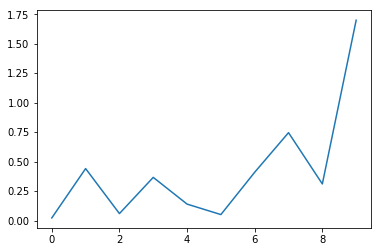

In [9]:
# plot the error trend of the 1st case
rt = np.array(rt)
plt.plot(np.arange(len(rt[0])),rt.mean(axis=0))

In [10]:
# train the model in the 2nd case
rt2=[]
t = 6 # the time index of re-training, which should be obtained in the second step
for j in range(1):
    regressor = GaussianProcessRegressor(random_state=j)
    regressor.fit(splits[t][:,:-1],splits[t][:,-1:])
    errs = []
    for i in range(t,len(tests)):
        test_id = i
        pre = regressor.predict(tests[i][:,:-1],return_std=False)
        err = MAPE(y_pred=pre*norm[i][-1],y_true=tests[i][:,-1:]*norm[i][-1])
        print('MAPE at step {}: {}'.format(i+1, err))
        errs.append(err)
    rt2.append(errs)

MAPE at step 7: 0.22053222598443978
MAPE at step 8: 0.134131496106682
MAPE at step 9: 0.05333233013948076
MAPE at step 10: 0.4505643130610927


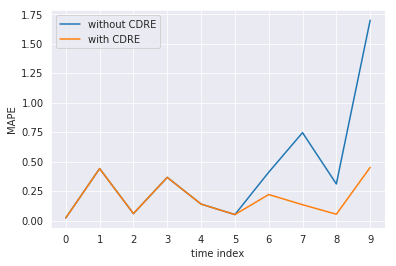

In [11]:
# visualize the difference of MAPE between the 1st and 2nd cases
rt2 = np.array(rt2)
rt2 = np.hstack([rt[0,:t],rt2[0]])
sns.set_style(style='darkgrid')
plt.plot(np.arange(len(rt[0])),rt.mean(axis=0))
plt.plot(np.arange(len(rt2)),rt2)
plt.xticks(np.arange(len(rt2)))
plt.xlabel('time index')
plt.ylabel('MAPE')
plt.legend(['without CDRE','with CDRE'])
plt.savefig('../results/stock/MSFT/mape.pdf')

### The following code is to visualize the  estimated KL-divergence with or without restart during the CDRE process

In [12]:
path = '../results/stock/MSFT/ori/' # the result path of CDRE estimations without restart in the second step
sd = os.listdir(path)
data = []
for s in sd:
    print(s)
    if '.' in s:
        continue
    ds = np.loadtxt(os.path.join(path,s,'divergence_compare.csv'), delimiter=',')
    data.append(ds)
    
kls = []
for d in data:
    kls.append(d[0])
kls = np.array(kls)

cl_ratio_test_d19_Tue-Apr-13-101744-2021
cl_ratio_test_d19_Tue-Apr-13-100059-2021
cl_ratio_test_d19_Tue-Apr-13-100927-2021
cl_ratio_test_d19_Tue-Apr-13-103304-2021
cl_ratio_test_d19_Tue-Apr-13-101406-2021
cl_ratio_test_d19_Tue-Apr-13-102915-2021
cl_ratio_test_d19_Tue-Apr-13-095641-2021
cl_ratio_test_d19_Tue-Apr-13-102430-2021
cl_ratio_test_d19_Tue-Apr-13-100424-2021
cl_ratio_test_d19_Tue-Apr-13-102103-2021


In [13]:
path = '../results/stock/MSFT/restart/' # the result path of CDRE estimations with restart in the second step
sd = os.listdir(path)
data = []
for s in sd:
    print(s)
    if '.' in s:
        continue
    ds = np.loadtxt(os.path.join(path,s,'divergence_compare.csv'), delimiter=',')
    data.append(ds)
rkls = []
for d in data:
    rkls.append(d[0])
rkls = np.array(rkls)

cl_ratio_test_d19_Tue-Apr-13-090220-2021
cl_ratio_test_d19_Tue-Apr-13-091950-2021
cl_ratio_test_d19_Tue-Apr-13-091330-2021
cl_ratio_test_d19_Tue-Apr-13-091133-2021
cl_ratio_test_d19_Tue-Apr-13-091735-2021
cl_ratio_test_d19_Tue-Apr-13-091550-2021
cl_ratio_test_d19_Tue-Apr-13-090425-2021
cl_ratio_test_d19_Tue-Apr-13-092142-2021
cl_ratio_test_d19_Tue-Apr-13-090859-2021
cl_ratio_test_d19_Tue-Apr-13-090633-2021


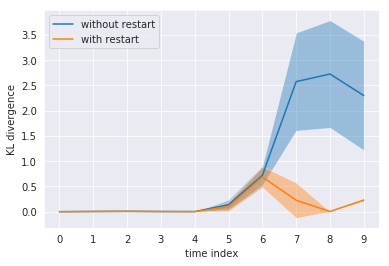

In [14]:
# visualize the estimated KL-divergences in both cases
sns.set_style(style='darkgrid')

plt.plot(np.arange(kls.shape[1]+1),np.concatenate([[0.],kls.mean(axis=0)]))
plt.plot(np.arange(rkls.shape[1]+1),np.concatenate([[0.],rkls.mean(axis=0)]))

plt.fill_between(np.arange(kls.shape[1])+1,kls.mean(axis=0)-kls.std(axis=0),kls.mean(axis=0)+kls.std(axis=0),alpha=0.4)
plt.fill_between(np.arange(rkls.shape[1])+1,rkls.mean(axis=0)-rkls.std(axis=0),rkls.mean(axis=0)+rkls.std(axis=0),alpha=0.4)
plt.xticks(np.arange(10))
plt.xlabel('time index')
plt.ylabel('KL divergence')
plt.legend(['without restart','with restart'],loc=2)
plt.savefig('../results/stock/MSFT/kl.pdf')